# Training/Optimizing a basic model with a Built Algorithm


## Summary:

This exercise is about executing all the steps of the Machine Learning development pipeline, using some features SageMaker offers. We'll use here a public dataset called iris. The dataset and the model aren't the focus of this exercise. The idea here is to see how SageMaker can accelerate your work and avoid wasting your time with tasks that aren't related to your business. So, we'll do the following:

<a id='contents' />

## Table of contents

1. [Train/deploy/test a multiclass model using XGBoost](#part1)
2. [Optimize the model](#part2)
3. [Run batch predictions](#part3)
4. [Check the monitoring results, created in **Part 1**](#part4)

<a id='part1' />

# 1. Train deploy and test
[(back to top)](#contents)

## Let's  start by importing the dataset and visualize it

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
sns.set(color_codes=True)

iris = datasets.load_iris()

X=iris.data
y=iris.target

dataset = np.insert(iris.data, 0, iris.target,axis=1)

df = pd.DataFrame(data=dataset, columns=['iris_id'] + iris.feature_names)
## We'll also save the dataset, with header, give we'll need to create a baseline for the monitoring
df.to_csv('full_dataset.csv', sep=',', index=None)
df['species'] = df['iris_id'].map(lambda x: 'setosa' if x == 0 else 'versicolor' if x == 1 else 'virginica')

df.head()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,0.0,5.1,3.5,1.4,0.2,setosa
1,0.0,4.9,3.0,1.4,0.2,setosa
2,0.0,4.7,3.2,1.3,0.2,setosa
3,0.0,4.6,3.1,1.5,0.2,setosa
4,0.0,5.0,3.6,1.4,0.2,setosa


In [7]:
df.describe()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.000000,5.843333,3.057333,3.758000,1.199333
std,0.819232,0.828066,0.435866,1.765298,0.762238
min,0.000000,4.300000,2.000000,1.000000,0.100000
25%,0.000000,5.100000,2.800000,1.600000,0.300000
50%,1.000000,5.800000,3.000000,4.350000,1.300000
75%,2.000000,6.400000,3.300000,5.100000,1.800000
max,2.000000,7.900000,4.400000,6.900000,2.500000


## Checking the class distribution

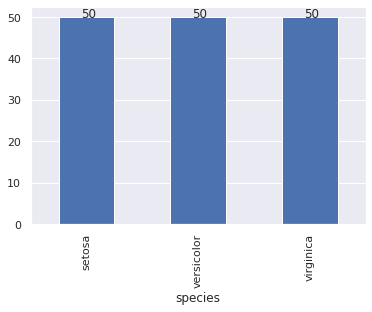

In [8]:
ax = df.groupby(df['species'])['species'].count().plot(kind='bar')
x_offset = -0.05
y_offset = 0
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

### Correlation Matrix

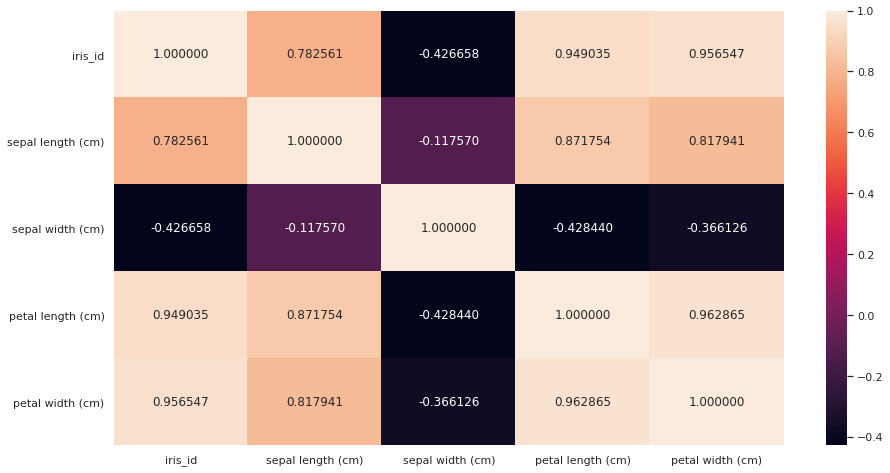

In [11]:
corr = df.corr()

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, annot=True, fmt="f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax);

### Pairplots & histograms

/usr/local/lib/python3.6/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


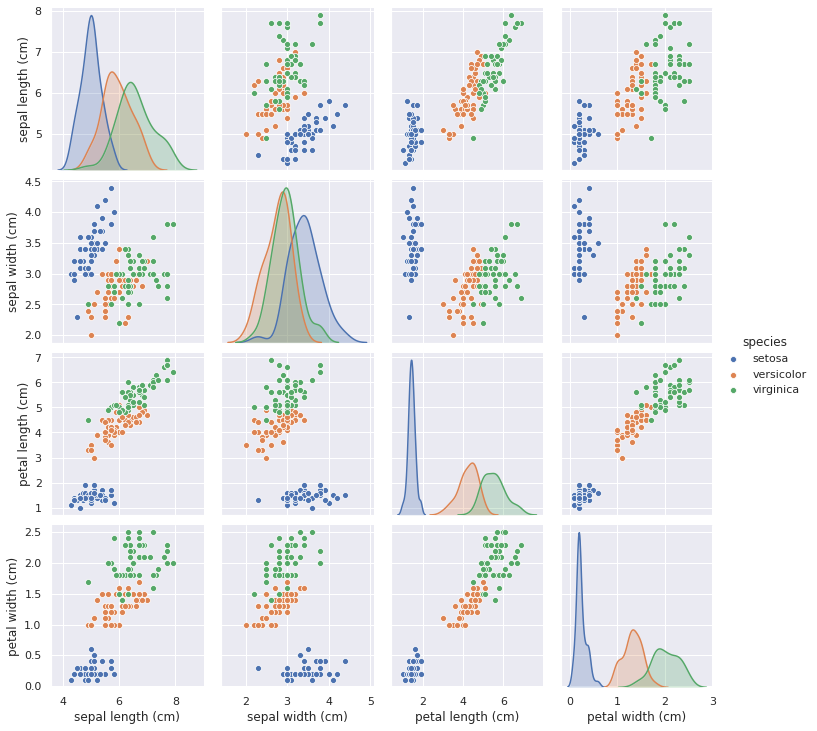

In [12]:
sns.pairplot(df.drop(['iris_id'], axis=1), hue='species', size=2.5,diag_kind="kde");

### Now with linear regression

/usr/local/lib/python3.6/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


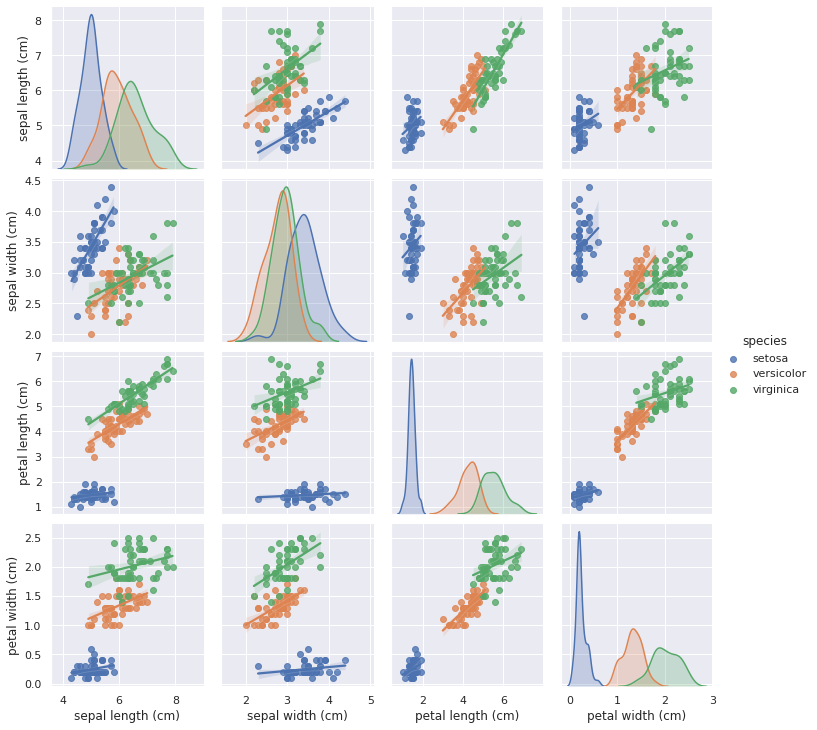

In [13]:
sns.pairplot(df.drop(['iris_id'], axis=1), kind="reg", hue='species', size=2.5,diag_kind="kde");

### Fit a plot a kernel density estimate.
We can see in this dimension an overlaping between **versicolor** and **virginica**. This is a better representation of what we identified above.

In [ ]:
tmp_df = df[(df.iris_id==0.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap="Blues", shade=False, shade_lowest=False)

tmp_df = df[(df.iris_id==1.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap="Greens", shade=False, shade_lowest=False)

tmp_df = df[(df.iris_id==2.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap="Reds", shade=False, shade_lowest=False)

plt.xlabel('species')

Ok. Petal length and petal width have the highest linear correlation with our label. Also, sepal width seems to be useless, considering the linear correlation with our label.

Since versicolor and virginica cannot be split linearly, we need a more versatile algorithm to create a better classifier. In this case, we'll use XGBoost, a tree ensable that can give us a good model for predicting the flower.

## Ok, now let's split the dataset into training and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

#### First we build the datasets with *X* and *y* for train and test:

In [ ]:
iris_train = pd.concat([X_train, y_train], axis = 1, ignore_index = True) 
iris_test = pd.concat([X_test, y_train], axis = 1, ignore_index = True)

#### Then we save the datasets:

In [ ]:
iris_train.to_csv('iris_train.csv', index = False)
iris_test.to_csv('iris_test.csv', index = False)

## Now it's time to train our model with the builtin algorithm XGBoost

In [ ]:
import sagemaker
import boto3

from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sklearn.model_selection import train_test_split

role = get_execution_role()

prefix='mlops/iris'
# Retrieve the default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

#### We will launch an async job to create the baseline for the monitoring process
A baseline is a what the monitoring will consider **normal**. 

The training dataset with which you trained the model is usually a good baseline dataset. Note that the training dataset data schema and the inference dataset schema should exactly match (i.e. the number and order of the features).

From the training dataset you can ask Amazon SageMaker to suggest a set of baseline constraints and generate descriptive statistics to explore the data. For this example, upload the training dataset that was used to train the pre-trained model included in this example. If you already have it in Amazon S3, you can directly point to it.

In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

endpoint_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

endpoint_monitor.suggest_baseline(
    baseline_dataset='full_dataset.csv',
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri='s3://{}/{}/monitoring/baseline'.format(bucket, prefix),
    wait=False,
    logs=False
)

#### Ok. Let's continue, upload the dataset and train the model

In [ ]:
# Upload the dataset to an S3 bucket
input_train = sagemaker_session.upload_data(path='iris_train.csv', key_prefix='%s/data' % prefix)
input_test = sagemaker_session.upload_data(path='iris_test.csv', key_prefix='%s/data' % prefix)

In [ ]:
train_data = sagemaker.session.s3_input(s3_data=input_train,content_type="csv")
test_data = sagemaker.session.s3_input(s3_data=input_test,content_type="csv")

**Note:** If there are other packages you want to use with your script, you can include a requirements.txt file in the same directory as your training script to install other dependencies at runtime. Both requirements.txt and your training script should be put in the same folder. You must specify this folder in `source_dir` argument when creating the estimator.

In [ ]:
# get the URI for new container
container_uri = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='0.90-2'); 

# Create the estimator
xgb = sagemaker.estimator.Estimator(container_uri,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)
# Set the hyperparameters
xgb.set_hyperparameters(eta=0.1,
                        max_depth=10,
                        gamma=4,
                        num_class=len(np.unique(y)),
                        alpha=10,
                        min_child_weight=6,
                        silent=0,
                        objective='multi:softmax',
                        num_round=30)

### Train the model

In [ ]:
%%time
# takes around 3min 11s
xgb.fit({'train': train_data, 'validation': test_data, })

### Deploy the model and create an endpoint for it
The following action will:
 * get the assets from the job we just ran and then create an input in the Models Catalog
 * create a endpoint configuration (a metadata for our final endpoint)
 * create an enpoint, which is our model wrapped in a format of a WebService
 
After that we'll be able to call our deployed endpoint for doing predictions

In [ ]:
%%time
# Enable log capturing in the endpoint
data_capture_configuration = sagemaker.model_monitor.data_capture_config.DataCaptureConfig(
    enable_capture=True, 
    sampling_percentage=100, 
    destination_s3_uri='s3://{}/{}/monitoring'.format(bucket, prefix), 
    sagemaker_session=sagemaker_session
)
xgb_predictor = xgb.deploy(
    initial_instance_count=1, 
    instance_type='ml.m4.xlarge',
    data_capture_config=data_capture_configuration
)

### Alright, now that we have deployed the endpoint, with data capturing enabled, it's time to setup the monitor
Let's start by configuring our predictor

In [ ]:
from sagemaker.predictor import csv_serializer
from sklearn.metrics import f1_score

endpoint_name = xgb_predictor.endpoint
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name
)['ProductionVariants'][0]['ModelName']

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

### *Monitoring*:
- We will generate a **baseline** for the monitoring. Yes, we can monitor a deployed model by collecting logs from the payload and the model output. SageMaker can suggest some statistics and constraints that can be used to compare with the collected data. Then we can see some **metrics** related to the **model performance**.
- We'll also create a monitoring scheduler. With this scheduler, SageMaker will parse the logs from time to time to compute the metrics we need. Given it takes some time to get the results, we'll check these metrics at the end of the exercice, in **Part 4**.

And then, we need to create a **Monitoring Schedule** for our endpoint. The command below will create a cron scheduler that will process the log each hour, then we can see how well our model is going.

In [ ]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

endpoint_monitor.create_monitoring_schedule(
    endpoint_input=endpoint_name,
    output_s3_uri='s3://{}/{}/monitoring/reports'.format(bucket, prefix),
    statistics=endpoint_monitor.baseline_statistics(),
    constraints=endpoint_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

### Just take a look on the baseline created/sugested by SageMaker for your dataset
This set of statistics and constraints will be used by the Monitoring Scheduler to compare the incoming data with what is considered **normal**. Each invalid payload sent to the endpoint will be considered a violation.

In [ ]:
baseline_job = endpoint_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
constraints_df = pd.io.json.json_normalize(baseline_job.suggested_constraints().body_dict["features"])
report_df = schema_df.merge(constraints_df)
report_df.drop([
    'numerical_statistics.distribution.kll.buckets',
    'numerical_statistics.distribution.kll.sketch.data',
    'numerical_statistics.distribution.kll.sketch.parameters.c'
], axis=1).head(10)

### Start generating some artificial traffic
The cell below starts a thread to send some traffic to the endpoint. Note that you need to stop the kernel to terminate this thread. If there is no traffic, the monitoring jobs are marked as `Failed` since there is no data to process.

In [ ]:
import random
import time 
from threading import Thread

traffic_generator_running=True
def invoke_endpoint_forever():
    print('Invoking endpoint forever!')
    while traffic_generator_running:
        ## This will create an invalid set of features
        ## The idea is to violate two monitoring constraings: not_null and data_drift
        null_idx = random.randint(0,3)
        sample = [random.randint(500,2000) / 100.0 for i in range(4)]
        sample[null_idx] = None
        xgb_predictor.predict(sample)
        time.sleep(0.5)
    print('Endpoint invoker has stopped')
Thread(target = invoke_endpoint_forever).start()

## Now, let's do a basic test with the deployed endpoint
In this test, we'll use a helper object called predictor. This object is always returned from a **Deploy** call. The predictor is just for testing purposes and we'll not use it inside our real application.

In [ ]:
predictions_test = [ float(xgb_predictor.predict(x).decode('utf-8')) for x in X_test] 
score = f1_score(y_test,predictions_test,labels=[0.0,1.0,2.0],average='micro')

print('F1 Score(micro): %.1f' % (score * 100.0))

## Then, let's  test the API for our trained model
This is how your application will call the endpoint. Using boto3 for getting a sagemaker runtime client and then we'll call invoke_endpoint

In [ ]:
from sagemaker.predictor import csv_serializer

sm = boto3.client('sagemaker-runtime')
resp = sm.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=csv_serializer(X_test[0])
)
prediction = float(resp['Body'].read().decode('utf-8'))
print('Predicted class: %.1f for [%s]' % (prediction, csv_serializer(X_test[0])) )

<a id='part2' />

# 2. Model optimization with Hyperparameter Tuning
[(back to top)](#contents)

## Hyperparameter Tuning Jobs
#### A.K.A. Hyperparameter Optimization

## Let's tune our model before using it for our batch prediction
We know that the iris dataset is an easy challenge. We can achieve a better score with XGBoost. However, we don't want to wast time testing all the possible variations of the hyperparameters in order to optimize the training process.

Instead, we'll use the Sagemaker's tuning feature. For that, we'll use the same estimator, but let's create a Tuner and ask it for optimize the model for us. 

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                         'gamma': ContinuousParameter(0, 10),
                        'max_depth': IntegerParameter(1, 10)}

objective_metric_name = 'validation:merror'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=4,
                            objective_type='Minimize')

tuner.fit({'train': train_data, 'validation': test_data, })

In [ ]:
tuner.wait()

In [ ]:
job_name = tuner.latest_tuning_job.name
attached_tuner = HyperparameterTuner.attach(job_name)
xgb_predictor2 = attached_tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [ ]:
first_endpoint_name = endpoint_name
endpoint_name = xgb_predictor2.endpoint
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name
)['ProductionVariants'][0]['ModelName']

## A simple test before we move on

In [ ]:
from sagemaker.predictor import csv_serializer
from sklearn.metrics import f1_score

xgb_predictor2.content_type = 'text/csv'
xgb_predictor2.serializer = csv_serializer
xgb_predictor2.deserializer = None

In [ ]:
predictions_test = [ float(xgb_predictor2.predict(x).decode('utf-8')) for x in X_test] 
score = f1_score(y_test,predictions_test,labels=[0.0,1.0,2.0],average='micro')

print('F1 Score(micro): %.1f' % (score * 100.0))

<a id='part3' />

# 3. Batch prediction
[(back to top)](#contents)


## Batch transform job
If you have a file with the samples you want to predict, just upload that file to an S3 bucket and start a Batch Transform job. For this task, you don't need to deploy an endpoint. Sagemaker will create all the resources needed to do this batch prediction, save the results into an S3 bucket and then it will destroy the resources automatically for you

In [ ]:
batch_dataset_filename='batch_dataset.csv'
with open(batch_dataset_filename, 'w') as csv:
    for x_ in X:
        line = ",".join( list(map(str, x_)) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

In [ ]:
input_batch = sagemaker_session.upload_data(path=batch_dataset_filename, key_prefix='%s/data' % prefix)

In [ ]:
import sagemaker

# Initialize the transformer object
transformer=sagemaker.transformer.Transformer(
    base_transform_job_name='mlops-iris',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path='s3://{}/{}/batch_output'.format(bucket, prefix),
)
# To start a transform job:
transformer.transform(input_batch, content_type='text/csv', split_type='Line')
# Then wait until transform job is completed
transformer.wait()

In [ ]:
import boto3

predictions_filename='iris_predictions.csv'
s3 = boto3.client('s3')
s3.download_file(bucket, '{}/batch_output/{}.out'.format(prefix, batch_dataset_filename), predictions_filename)

df2 = pd.read_csv(predictions_filename, sep=',', encoding='utf-8',header=None, names=[ 'predicted_iris_id'])
df3 = df.copy()
df3['predicted_iris_id'] = df2['predicted_iris_id']
df3.head()

In [ ]:
from sklearn.metrics import f1_score
score = f1_score(df3['iris_id'], df3['predicted_iris_id'],labels=[0.0,1.0,2.0],average='micro')

print('F1 Score(micro): %.1f' % (score * 100.0))

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(df3['iris_id'], df3['predicted_iris_id'])

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(cnf_matrix, annot=True, fmt="f", mask=np.zeros_like(cnf_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

<a id='part4' />

# 4. Check the monitoring results
[(back to top)](#contents)

The HPO took something like 20 minutes to run. The batch prediction, 3-5 more. It is probably enough time to have at least one execution of the monitor schedule. Since we created a thread for generating **invalid** features, we must have some data drift detected in our monitoring. Let's check

In [ ]:
mon_executions = endpoint_monitor.list_executions()
print("We created a hourly schedule above and it will kick off executions ON the hour (plus 0 - 20 min buffer.\nWe will have to wait till we hit the hour...")

while len(mon_executions) == 0:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = endpoint_monitor.list_executions()
print('OK. we have %d execution(s) now' % len(mon_executions))

In [ ]:
import time
import pandas as pd
from IPython.display import display, HTML

def print_constraint_violations():
    violations = endpoint_monitor.latest_monitoring_constraint_violations()
    pd.set_option('display.max_colwidth', -1)
    constraints_df = pd.io.json.json_normalize(violations.body_dict["violations"])
    display(HTML(constraints_df.head(10).to_html()))
    
while True:
    resp = mon_executions[-1].describe()
    status = resp['ProcessingJobStatus']
    msg = resp['ExitMessage']
    if status == 'InProgress':
        time.sleep(30)
    elif status == 'Completed':
        print("Finished: %s" % msg)
        print_constraint_violations()
        break
    else:
        print("Error: %s" % msg)
        break

You can also check these metrics on CloudWatch. Just open the CloudWatch console, click on **Metrics**, then select:
    All -> aws/sagemaker/Endpoints/data-metrics -> Endpoint, MonitoringSchedule

Use the *endpoint_monitor* name to filter the metrics

## Cleaning up

In [ ]:
traffic_generator_running=False
time.sleep(3)
endpoint_monitor.delete_monitoring_schedule()
time.sleep(10) # wait for 10 seconds before trying to delete the endpoint

In [ ]:
xgb_predictor.delete_endpoint()
xgb_predictor2.delete_endpoint()

# The end